#A Comparison of Automatic Music Genre Classification Deep Learning Techniques
#Christian Francis
#219037993




#Imports


Mounting Drive

In [1]:
 #from google.colab import drive
 #drive.mount('/content/drive')

Importing Libraries

In [2]:
import pandas as pd
import time
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [3]:
#data = pd.read_csv("/content/drive/MyDrive/Honours/Data/features_3_sec.csv")
data = pd.read_csv("/content/features_3_sec.csv")

#Visualization

In [4]:
#Data preprocessing and visualization were inspired by the following notebook:

"""
Title: Music Genre Classification using CNN
Author:Sharma,S
Date: 2021
Code Version: 3.0
Availability:https://www.kaggle.com/code/soumyasharma20/music-genre-classification-using-cnn/notebook#Feature-Extraction

"""

'\nTitle: Music Genre Classification using CNN\nAuthor:Sharma,S\nDate: 2021\nCode Version: 3.0\nAvailability:https://www.kaggle.com/code/soumyasharma20/music-genre-classification-using-cnn/notebook#Feature-Extraction\n\n'

In [5]:
data=data.drop(labels="filename",axis=1)

In [6]:
audio_recording="/content/country.00050.wav"
d,sr=librosa.load(audio_recording)
print(type(data),type(sr))

<class 'pandas.core.frame.DataFrame'> <class 'int'>


Raw wave files

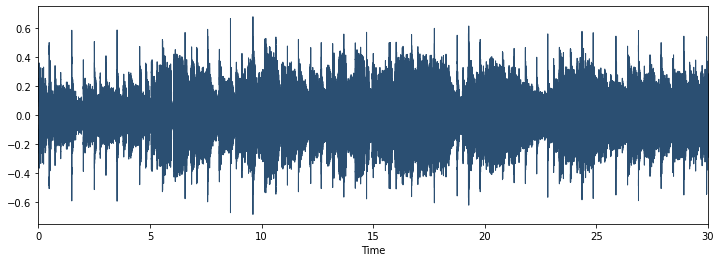

In [7]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(d,color="#2B4F72")
plt.show()

Spectrogram

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


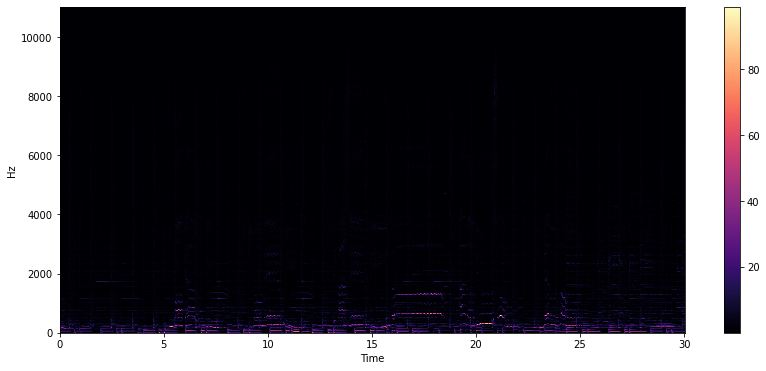

In [8]:
stft=librosa.stft(d)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

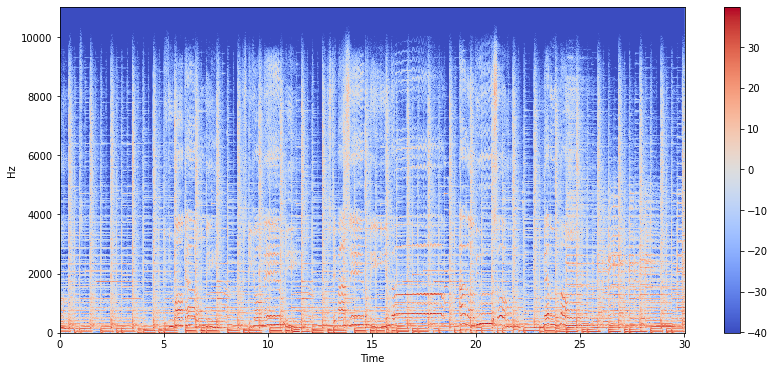

In [9]:
stft=librosa.stft(d)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

Spectral Roll off

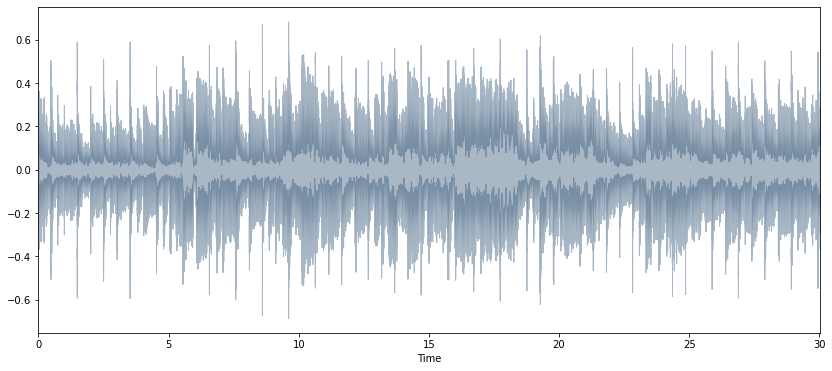

In [10]:
spectral_rolloff=librosa.feature.spectral_rolloff(d+0.01,sr=sr)[0]
plt.figure(figsize=(14,6))
librosa.display.waveplot(d,sr=sr,alpha=0.4,color="#2B4F72")

Chroma Feature

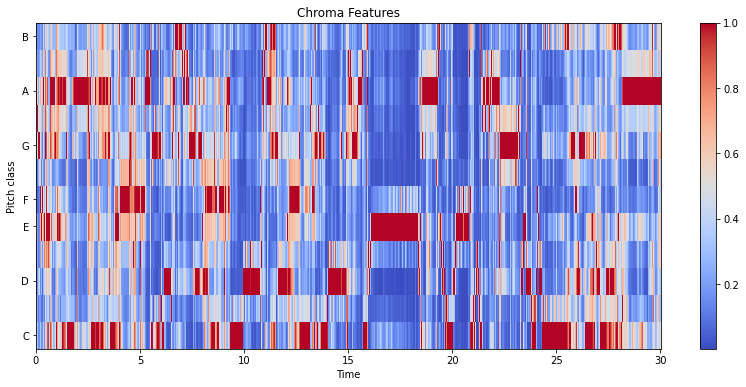

In [11]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(d,sr=sr)
plt.figure(figsize=(14,6))
lplt.specshow(chroma,sr=sr,x_axis="time",y_axis="chroma",cmap="coolwarm")
plt.colorbar()
plt.title("Chroma Features")
plt.show()

Zero Crossing Rate

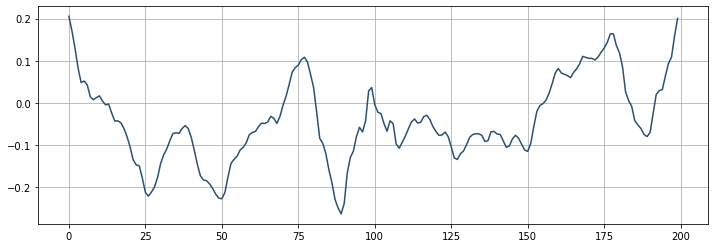

In [12]:
start=1000
end=1200
plt.figure(figsize=(12,4))
plt.plot(d[start:end],color="#2B4F72")
plt.grid()

In [13]:
zero_cross_rate=librosa.zero_crossings(d[start:end],pad=False)
print("zero_crossings :", sum(zero_cross_rate))

zero_crossings : 8


#Data Preprocessing

#Feature Extraction

In [14]:
# Convert categorical data into numerical data that the model will understand
classList=data.iloc[:,-1]
labelEnc= LabelEncoder()

# Fitting label encoder and return the encoded labels
y=labelEnc.fit_transform(classList)


In [15]:
print(data.iloc[:,:-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

#Scaling Features

In [16]:
#Standard Scaler from the sklearn library is used to standardize the features by removing mean and scaling to unit variance
fit=StandardScaler()

X= fit.fit_transform(np.array(data.iloc[:, : -1], dtype=float))


#Splitting Training and Testing Sets

In [17]:
#I plan to test with training sets of 90%, 75%, 66%

#90% Training, 10% testing
#Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.10) 

#70% Training, 25% testing
#Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.25) 

#66% Training, 34% testing
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.34) 

In [18]:
#print( "length of ytest :", len(ytest))
#print("Length of ytrain",len(ytrain))

#Model

#CNN

In [19]:
def cnn_model():

    model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(Xtrain.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),

])
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model

model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [20]:
#Cross validation implementation on CNN and RNN inspired by the folloiwng notebook:

"""
Title: Basic CNN Keras with cross validation
Author:Muchahary, F
Date: 2018
Code Version: 4.0
Availability:https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation

"""

#set early stopping criteria

pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('cnn_check.h5', verbose=1, save_best_only=True)

def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=600, BATCH_SIZE=128):
    model = None
    model = cnn_model()
    results = model.fit(t_x, t_y,validation_data=(val_x,val_y),epochs=EPOCHS,batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [21]:
n_folds=10
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    #need to change this value as well when testing

    t_x, val_x, t_y, val_y = train_test_split(Xtrain, ytrain, test_size=0.34, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))

    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
18/34 [==============>...............] - ETA: 0s - loss: 1.9940 - accuracy: 0.2821  
Epoch 1: val_loss improved from inf to 1.30713, saving model to cnn_check.h5
34/34 [==============================] - 3s 10ms/step - loss: 1.8030 - accuracy: 0.3452 - val_loss: 1.3071 - val_accuracy: 0.5401
Epoch 2/20
19/34 [===============>..............] - ETA: 0s - loss: 1.3644 - accuracy: 0.5214
Epoch 2: val_loss improved from 1.30713 to 1.03590, saving model to cnn_check.h5
34/34 [==============================] - 0s 5ms/step - loss: 1.3064 - accuracy: 0.5422 - val_loss: 1.0359 - val_accuracy: 0.6427
Epoch 3/20
28/34 [=======================>......] - ETA: 0s - loss: 1.0667 - accuracy: 0.6300
Epoch 3: val_loss improved from 1.03590 to 0.84937, saving model to cnn_check.h5
34/34 [==============================] - 0s 7ms/step - loss: 1.0636 - accuracy: 0.6300 - val_loss: 0.8494 - val_accuracy: 0.7123
Epoch 4/20
19/34 [===============>..............] - ETA: 0s - loss: 

Cnn Model Evaluation


In [22]:
#Load the model that was saved by ModelCheckpoint
model = load_model('cnn_check.h5')

loss,accuracy=model.evaluate(Xtest,ytest,batch_size=128)
print("Test Loss :",loss)
print("Test Accuracy :",accuracy)

27/27 [==============================] - 0s 2ms/step - loss: 0.5110 - accuracy: 0.8484
Test Loss : 0.5110496282577515
Test Accuracy : 0.8483956456184387


#RNN

In [23]:
def rnn_model():

    model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512,input_shape=(Xtrain.shape[1],1),return_sequences= True),
    tf.keras.layers.LSTM(512),
        # dense layer
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),  

    
     # output layer
    tf.keras.layers.Dense(10,activation='softmax'),

])
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model


model = rnn_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 58, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_55 (Dense)            (None, 256)               131328    
                                                                 
 dropout_44 (Dropout)        (None, 256)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               32896     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 64)              

In [24]:
#set early stopping criteria

pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('rnn_check.h5', verbose=1, save_best_only=True)

def rnn_fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=600, BATCH_SIZE=128):
    model = None
    model = rnn_model()
    results = model.fit(t_x, t_y,validation_data=(val_x,val_y),epochs=EPOCHS,batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [25]:
n_folds=10
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    #need to change this value as well when testing

    t_x, val_x, t_y, val_y = train_test_split(Xtrain, ytrain, test_size=0.34, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(rnn_fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
33/34 [============================>.] - ETA: 0s - loss: 2.1335 - accuracy: 0.1868
Epoch 1: val_loss improved from inf to 1.88512, saving model to rnn_check.h5
34/34 [==============================] - 9s 83ms/step - loss: 2.1306 - accuracy: 0.1903 - val_loss: 1.8851 - val_accuracy: 0.2797
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.8577 - accuracy: 0.2965
Epoch 2: val_loss improved from 1.88512 to 1.80183, saving model to rnn_check.h5
34/34 [==============================] - 2s 62ms/step - loss: 1.8577 - accuracy: 0.2965 - val_loss: 1.8018 - val_accuracy: 0.3363
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.8598 - accuracy: 0.3059
Epoch 3: val_loss improved from 1.80183 to 1.76514, saving model to rnn_check.h5
34/34 [==============================] - 2s 59ms/step - loss: 1.8598 - accuracy: 0.3059 - val_loss: 1.7651 - val_accuracy: 0.3167
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 

RNN Model Evaluation

In [26]:
#Load the model that was saved by ModelCheckpoint
model = load_model('rnn_check.h5')

loss,accuracy=model.evaluate(Xtest,ytest,batch_size=128)
print("Test Loss :",loss)
print("Test Accuracy :",accuracy)

27/27 [==============================] - 2s 21ms/step - loss: 1.2836 - accuracy: 0.5381
Test Loss : 1.2836203575134277
Test Accuracy : 0.5381218791007996


#Multilayer Perceptron

In [27]:
kfold = StratifiedKFold(n_splits=10)
clf=MLPClassifier(alpha=0.01, 
                   batch_size=256, 
                   epsilon=1e-08, 
                   hidden_layer_sizes=(300,), 
                   learning_rate='adaptive', 
                   max_iter=400)
#clf.fit(Xtrain,ytrain)
#y_pred=clf.predict(Xtest)

In [28]:
cv_result= cross_val_score(clf, Xtrain, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=4)
cv_means=cv_result.mean()
cv_std=cv_result.std()


MLP Classifier Evaluation

In [29]:
print( "mean accuracy:", cv_means)

mean accuracy: 0.8882144663631767
